In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

import sklearn

from sklearn.preprocessing import scale
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder

import sklearn.preprocessing

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import model_selection
from sklearn import metrics

mpl.rcParams['font.family'] = "serif"
mpl.rcParams['text.usetex'] = True
mpl.rcParams['ytick.right'] = True
mpl.rcParams['ytick.direction'] = "in"
mpl.rcParams['xtick.top'] = True
mpl.rcParams['xtick.direction'] = "in"
mpl.rcParams['axes.titlesize'] = 20
mpl.rcParams['axes.labelsize'] = 20
mpl.rcParams['xtick.labelsize'] = 16
mpl.rcParams['ytick.labelsize'] = 16
mpl.rcParams['legend.fontsize'] = 20
mpl.rcParams['figure.dpi'] = 100
mpl.rcParams['savefig.dpi'] = 100
mpl.rcParams['figure.figsize'] = (6,4)
plt.rcParams['axes.labelweight'] = 'bold'
mpl.rcParams['text.latex.preamble']=[r"\usepackage{amsmath}"]    

def y_by_x(self, y, x, width=1):
    ''' Group dataframe values y by values x binned by width. Default binning of x is 1.
    x and y can be column names or transformations interpretable by the eval method.  
    '''
    grps = self.eval(x).apply(lambda t: int(t/float(width))*float(width) if not pd.isna(t) else t) 
    values = self.eval(y)
    return values.groupby(grps)

pd.DataFrame.y_by_x = y_by_x

def plot_pd_series(series, **kwargs):
    plt.plot(series.index, series.values, **kwargs, marker='o')
    
def find_nearest_idx(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

### Begin by loading in the cleaned and windowed dataset

In [3]:
injs = pd.read_csv('inj_data_final.csv')
injs.drop(columns=['Unnamed: 0','Opp','Team'],inplace=True)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (104,113,122) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
injs.shape

(133072, 126)

#### Use One Hot Encoding on our catergorical data. We'll get rid of the team, and opp catergories

In [5]:
enc = OneHotEncoder(sparse=False)
vals = enc.fit_transform(injs[['Position','Pos3','Shoots']])
cols = []
for cat in enc.categories_:
    cols = np.concatenate((cols,cat))
oneHot_cols = pd.DataFrame(vals,columns=cols)
injs = pd.concat((injs,oneHot_cols),axis=1)
injs.fillna(value=0,inplace=True) #Fill NaNs with 0
injs = injs.loc[injs['Name']!=0]

In [6]:
injs.drop(columns=['Position','Pos3','Shoots'],inplace=True)

#### Get rid of spaces in our column names, and '?'

In [7]:
col_dict = {}
col_dict['Was_Injured?'] = 'Was_Injured'

for c in injs.columns:
    strng = c.replace(' ','_')
    strng = strng.replace('.','')
    strng = strng.replace('%','_per')
    if strng != c:
        col_dict[c] = strng

injs.rename(columns=col_dict,inplace=True)    

#### Let's take a look at the columns in our final data

In [8]:
for c in injs.columns:
    print(c)

Name
Height_[cm]
Weight_[kg]
Date
Age
Was_Injured
MP_Av7
FG_Av7
FGA_Av7
FG_per_Av7
3P_Av7
3PA_Av7
3P_per_Av7
FT_Av7
FTA_Av7
FT_per_Av7
ORB_Av7
DRB_Av7
TRB_Av7
AST_Av7
STL_Av7
BLK_Av7
TOV_Av7
PF_Av7
PTS_Av7
GmSc_Av7
+/-_Av7
N_games_7
MP_Av14
FG_Av14
FGA_Av14
FG_per_Av14
3P_Av14
3PA_Av14
3P_per_Av14
FT_Av14
FTA_Av14
FT_per_Av14
ORB_Av14
DRB_Av14
TRB_Av14
AST_Av14
STL_Av14
BLK_Av14
TOV_Av14
PF_Av14
PTS_Av14
GmSc_Av14
+/-_Av14
N_games_14
MP_Av21
FG_Av21
FGA_Av21
FG_per_Av21
3P_Av21
3PA_Av21
3P_per_Av21
FT_Av21
FTA_Av21
FT_per_Av21
ORB_Av21
DRB_Av21
TRB_Av21
AST_Av21
STL_Av21
BLK_Av21
TOV_Av21
PF_Av21
PTS_Av21
GmSc_Av21
+/-_Av21
N_games_21
MP_b2b
FG_b2b
FGA_b2b
FG_per_b2b
3P_b2b
3PA_b2b
3P_per_b2b
FT_b2b
FTA_b2b
FT_per_b2b
ORB_b2b
DRB_b2b
TRB_b2b
AST_b2b
STL_b2b
BLK_b2b
TOV_b2b
PF_b2b
PTS_b2b
GmSc_b2b
+/-_b2b
b2b
N_prev_injs
ann_inj_rate
W_Av_7
L_Av_7
Dist_Feet_Av_7
Dist_Miles_Av_7
Dist_Miles_Off_Av_7
Dist_Miles_Def_Av_7
Avg_Speed_Av_7
Avg_Speed_Off_Av_7
Avg_Speed_Def_Av_7
W_Av_14
L_Av_14
D

In [9]:
injs.shape

(133072, 144)

In [10]:
avg_inj_rate = injs.loc[injs['Was_Injured']==1].shape[0]/injs.shape[0]
print("Overall injury rate in the data set is {:.2f}%".format(avg_inj_rate*100))

Overall injury rate in the data set is 2.92%


### To begin, we'll take a look at the correlations between our features and injuries

In [11]:
correlations = injs.corr()['Was_Injured']
sort = correlations[np.argsort(np.abs(correlations))][::-1]

In [13]:
sort[:50]

Was_Injured            1.000000
N_prev_injs            0.064922
N_games_14            -0.025015
N_games_7             -0.024008
N_games_21            -0.021283
FT_Av21                0.020598
FGA_Av21               0.020024
FTA_Av21               0.019952
AST_Av21               0.019663
W_Av_14               -0.019402
TOV_Av14               0.019193
TOV_Av21               0.019071
FGA_Av14               0.019052
PTS_Av21               0.018924
W_Av_21               -0.018915
AST_Av14               0.018738
FT_Av14                0.018225
FG_Av21                0.018019
GmSc_Av21              0.018006
ann_inj_rate           0.017371
PTS_Av14               0.017273
FTA_Av14               0.017253
FGA_Av7                0.017019
FG_Av14                0.016749
AST_Av7                0.016552
Avg_Speed_Def_Av_21   -0.015904
TOV_Av7                0.015901
W_Av_7                -0.015794
GmSc_Av14              0.015790
PTS_Av7                0.014934
Avg_Speed_Av_21       -0.014774
FG_Av7  

#### To take a look at these correlations in more detail, we bin the data by a given feature, and then calculate the average value of 'Was_Injured' in that bin

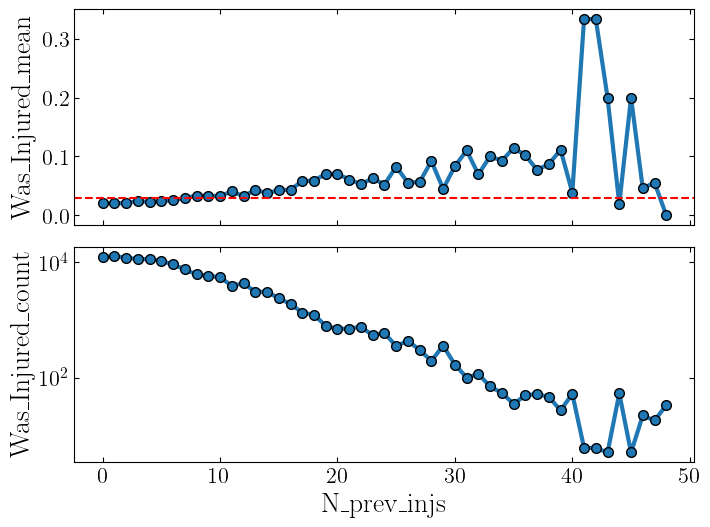

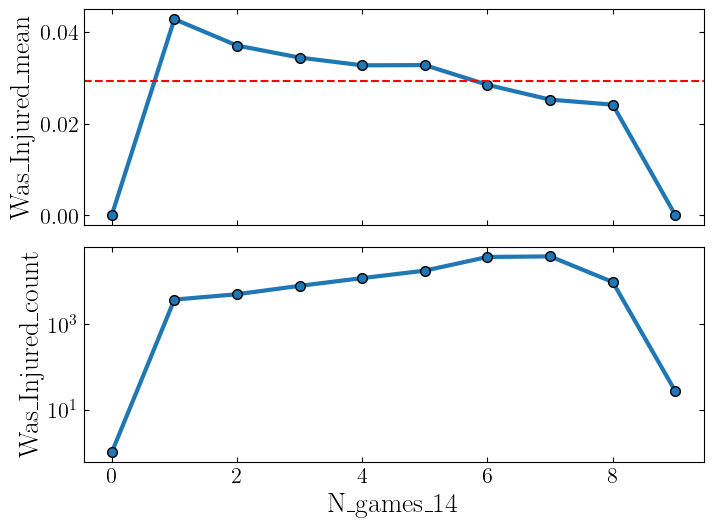

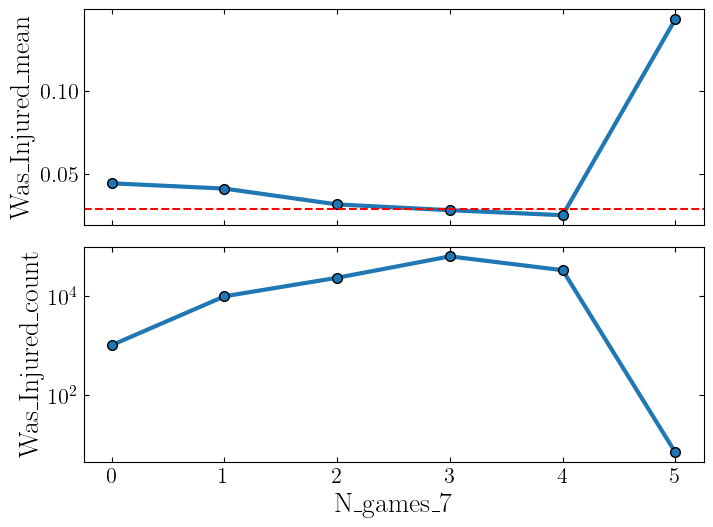

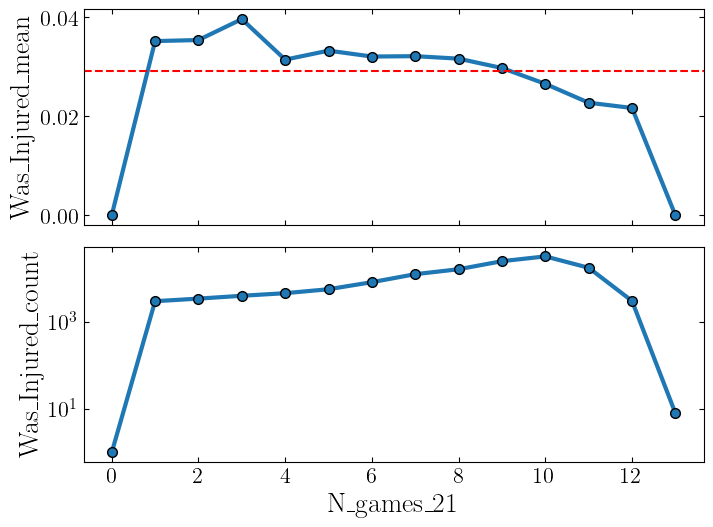

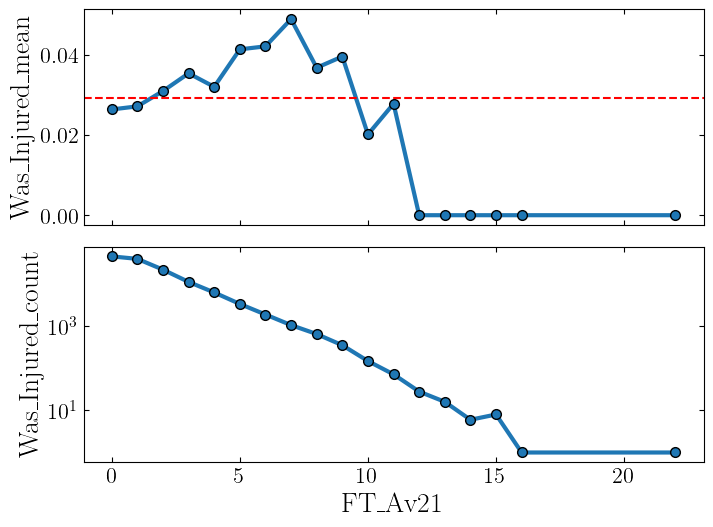

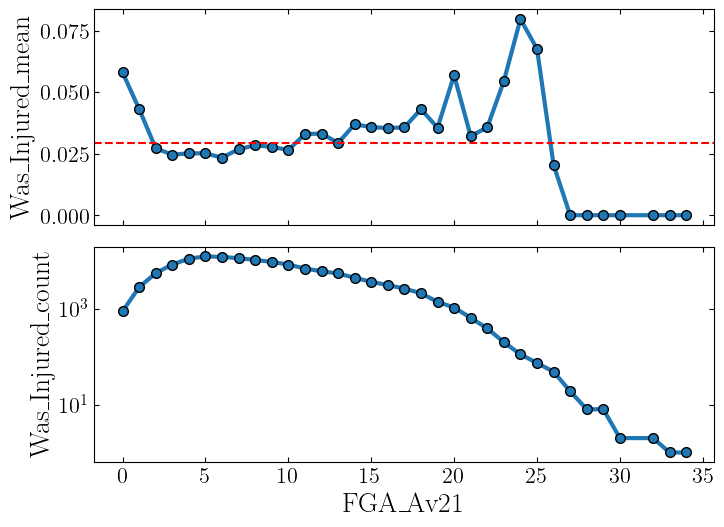

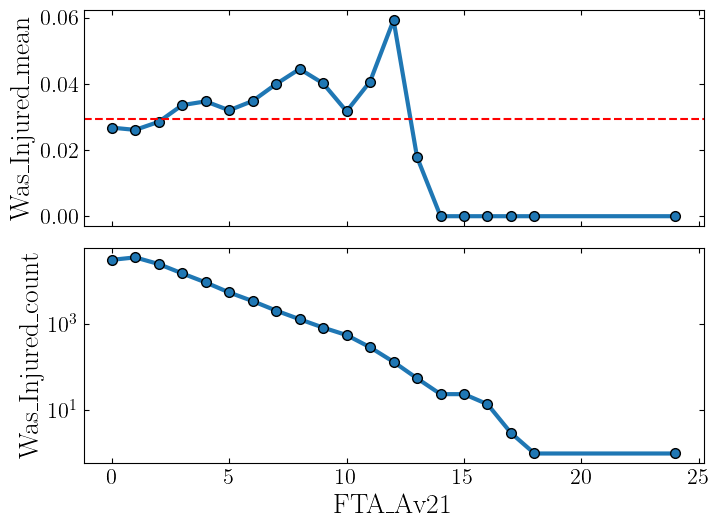

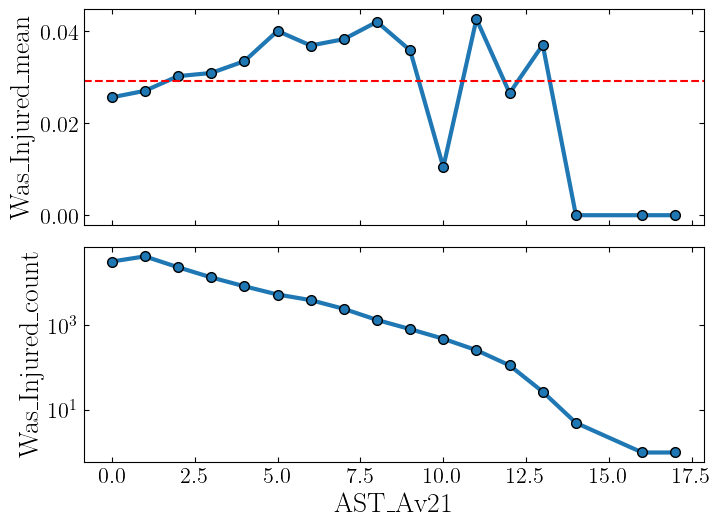

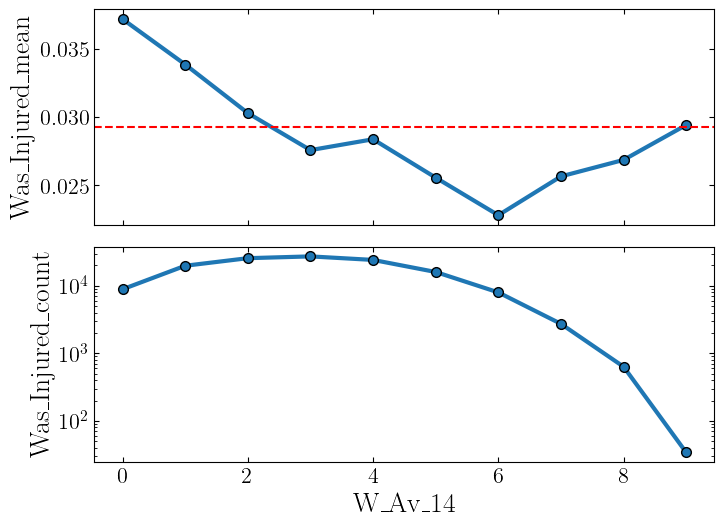

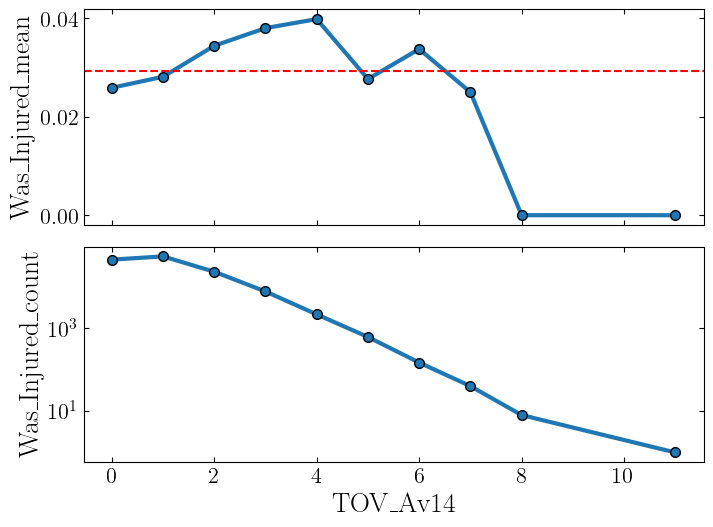

In [14]:
col_y = 'Was_Injured'

for col_x in sort[1:11].index:
    
    width = 0.1 if col_x[:3] == 'Avg' else 1
    
    means = injs.y_by_x(col_y,col_x,width=width).mean()
    counts = injs.y_by_x(col_y,col_x,width=width).count()
    fig, (ax1,ax2) = plt.subplots(2,1,sharex=True,figsize=(8,6),gridspec_kw = {'hspace': 0.1})

    plt.sca(ax1)
    plot_pd_series(means,lw=3,mec='k',ms=7)
    plt.ylabel((col_y + "_mean").replace('_','\_'))
    plt.axhline(y=avg_inj_rate,linestyle='dashed',color='r')

    plt.sca(ax2)
    plot_pd_series(counts,lw=3,mec='k',ms=7)
    plt.yscale('log')
    plt.ylabel((col_y + r"_count").replace('_','\_'))
    plt.xlabel(col_x.replace('_','\_'))

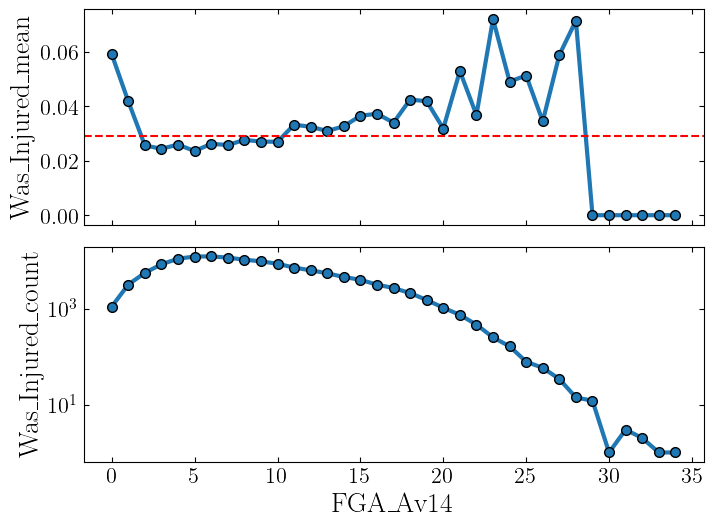

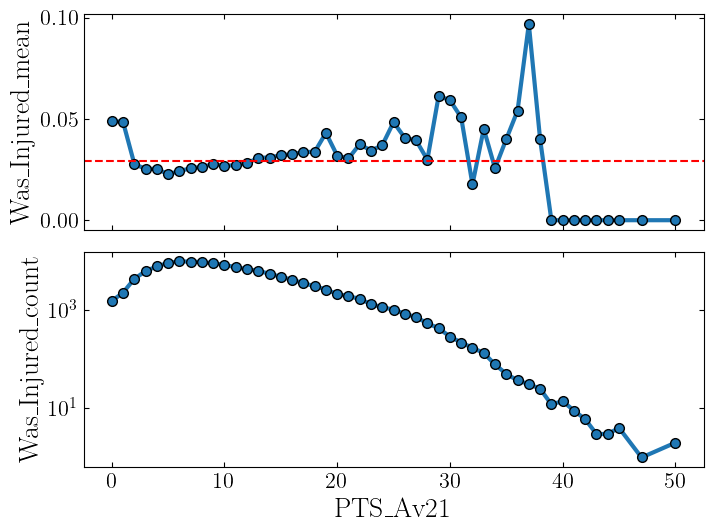

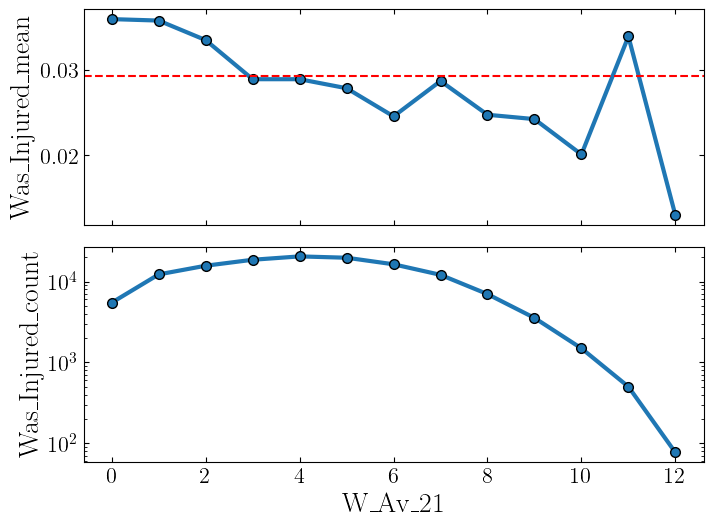

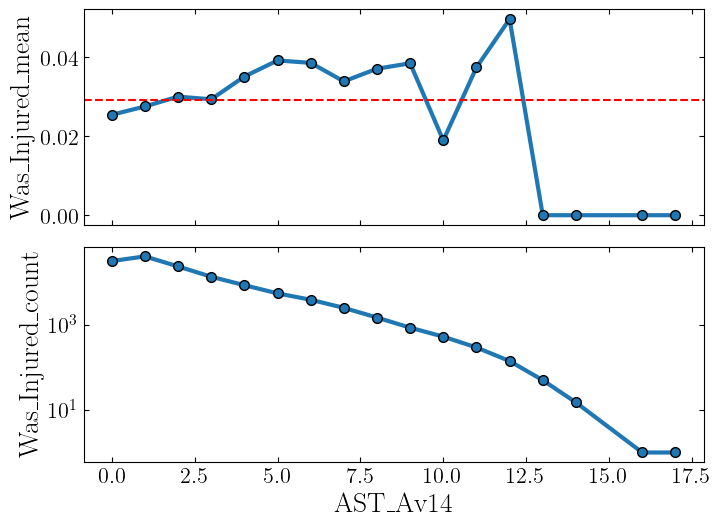

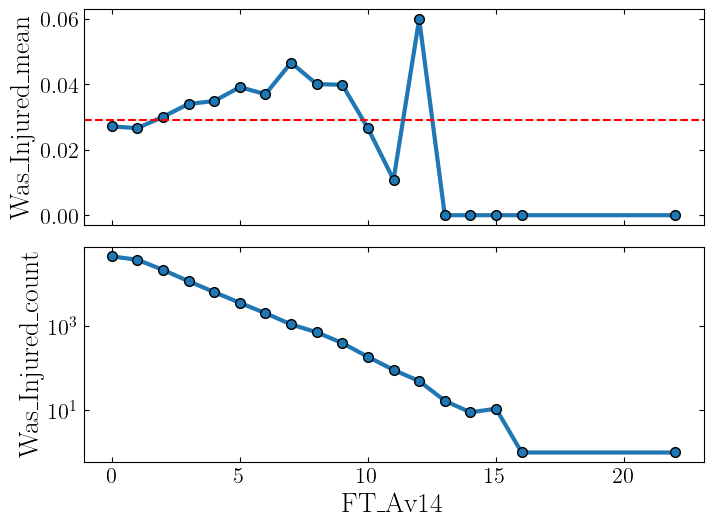

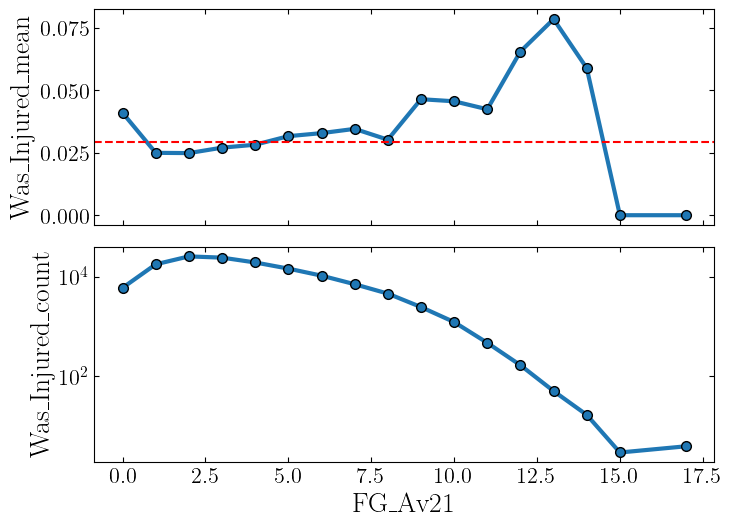

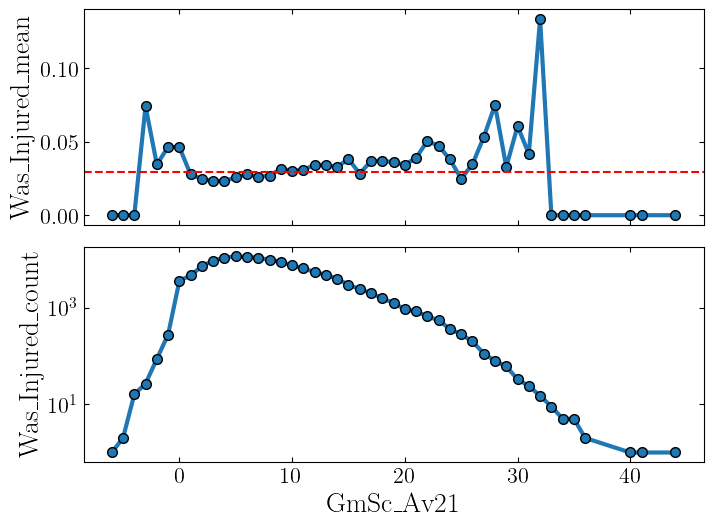

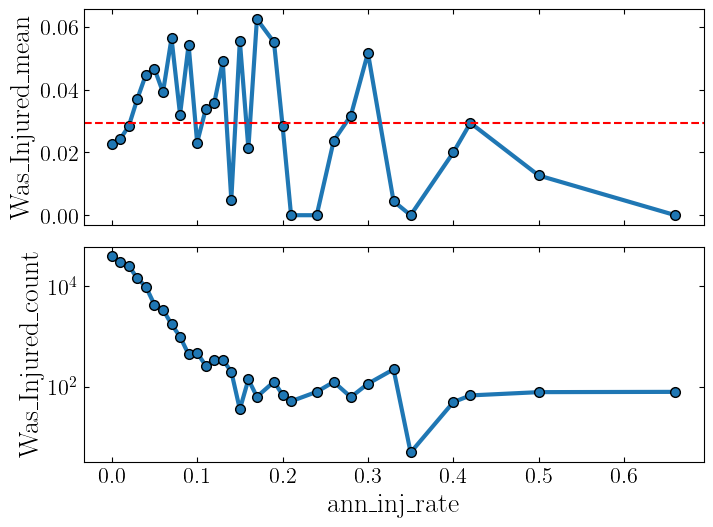

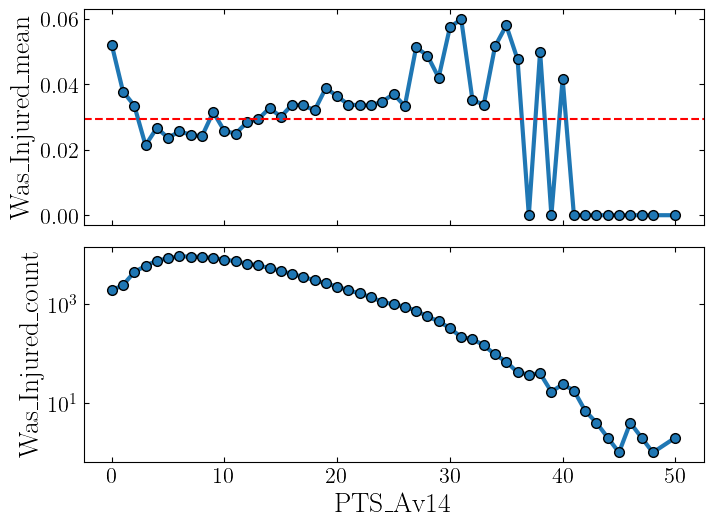

In [15]:
for col_x in sort[12:21].index:
    
    if col_x[:3] == 'Avg':
        width = 0.1
    elif col_x[:3] == 'ann':
        width = 1e-2
    else:
        width = 1
    
    means = injs.y_by_x(col_y,col_x,width=width).mean()
    counts = injs.y_by_x(col_y,col_x,width=width).count()
    fig, (ax1,ax2) = plt.subplots(2,1,sharex=True,figsize=(8,6),gridspec_kw = {'hspace': 0.1})

    plt.sca(ax1)
    plot_pd_series(means,lw=3,mec='k',ms=7)
    plt.ylabel((col_y + "_mean").replace('_','\_'))
    plt.axhline(y=avg_inj_rate,linestyle='dashed',color='r')

    plt.sca(ax2)
    plot_pd_series(counts,lw=3,mec='k',ms=7)
    plt.yscale('log')
    plt.ylabel((col_y + r"_count").replace('_','\_'))
    plt.xlabel(col_x.replace('_','\_'))

### Let's zoom in on the Average speed plots

(3.0, 4.5)

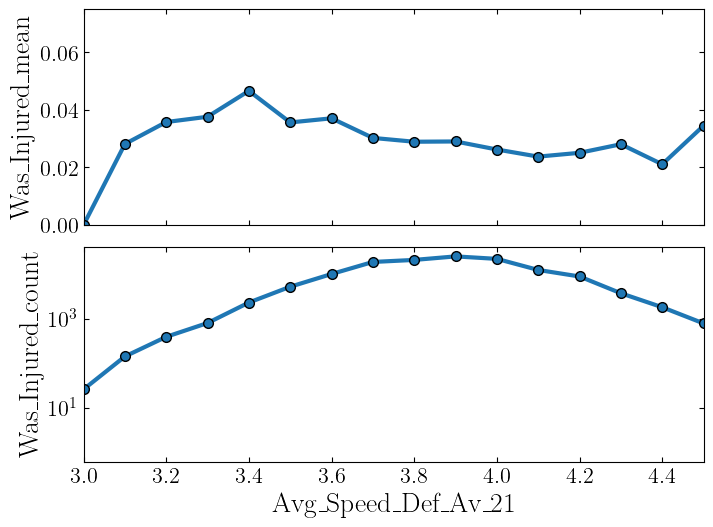

In [16]:
col_x = 'Avg_Speed_Def_Av_21'

means = injs.y_by_x(col_y,col_x,width=0.1).mean()
counts = injs.y_by_x(col_y,col_x,width=0.1).count()

fig, (ax1,ax2) = plt.subplots(2,1,sharex=True,figsize=(8,6),gridspec_kw = {'hspace': 0.1})

plt.sca(ax1)
plot_pd_series(means,lw=3,mec='k',ms=7)
plt.ylabel((col_y + "_mean").replace('_','\_'))
plt.xlim(3.0,4.5)
plt.ylim(0,0.075)

plt.sca(ax2)
plot_pd_series(counts,lw=3,mec='k',ms=7)
plt.yscale('log')
plt.ylabel((col_y + r"_count").replace('_','\_'))
plt.xlabel(col_x.replace('_','\_'))

plt.xlim(3.0,4.5)

### There's lots of noise in the features, but that appears to be generally correlated with low numbers of bin counts.  Let's try a logistic regression on the 30 features with the highest correlations, but we'll drop those that are the same stat with a different window, favoring the one with the higher correlation coefficient

In [17]:
indices = sort.index[1:]
stats = {}
i = 0
best_inds = []
while len(stats)<30:
    key = indices[i][:3]
    if not(key in stats):
        stats[key] = None
        best_inds.append(indices[i])
    i+=1

In [84]:
best_inds

['N_prev_injs',
 'N_games_14',
 'FT_Av21',
 'FGA_Av21',
 'FTA_Av21',
 'AST_Av21',
 'W_Av_14',
 'TOV_Av14',
 'PTS_Av21',
 'FG_Av21',
 'GmSc_Av21',
 'ann_inj_rate',
 'Avg_Speed_Def_Av_21',
 'PF_b2b',
 'Age',
 'b2b',
 'MP_b2b',
 '3P_per_b2b',
 'TRB_b2b',
 'STL_b2b',
 'DRB_b2b',
 'ORB_b2b',
 'Guard',
 'Shooting_Guard',
 '3PA_Av21',
 'Dist_Miles_Off_Av_21',
 'L_Av_7',
 'Power_Forward',
 'BLK_Av14',
 'Point_Guard_and_Shooting_Guard']

### Begin the regression

In [54]:
X = injs[best_inds]
y = injs['Was_Injured']

#### Let's just see how well our classifer can do using the $F_1$ score as a metric. We'll first do a grid search using 5-fold cross validation on the amount of regularization and the class weights

In [55]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
scaler = sklearn.preprocessing.StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [29]:
params = [{'class_weight' : [{0:1,1:1},{0:1,1:3},{0:1,1:6},{0:1,1:10},{0:1,1:15},{0:1,1:40}\
                    ,{0:1,1:50},{0:1,1:70}],'C': np.logspace(-3,3,num=7)}]
       
model=LogisticRegression(max_iter=10000,n_jobs=3)

clf = model_selection.GridSearchCV(model,params,scoring='f1',verbose=3)

clf.fit(X_train,y_train)

Fitting 5 folds for each of 56 candidates, totalling 280 fits
[CV] C=0.001, class_weight={0: 1, 1: 1} ..............................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .. C=0.001, class_weight={0: 1, 1: 1}, score=0.000, total=   0.9s
[CV] C=0.001, class_weight={0: 1, 1: 1} ..............................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s


[CV] .. C=0.001, class_weight={0: 1, 1: 1}, score=0.000, total=   0.8s
[CV] C=0.001, class_weight={0: 1, 1: 1} ..............................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.7s remaining:    0.0s


[CV] .. C=0.001, class_weight={0: 1, 1: 1}, score=0.000, total=   0.5s
[CV] C=0.001, class_weight={0: 1, 1: 1} ..............................
[CV] .. C=0.001, class_weight={0: 1, 1: 1}, score=0.000, total=   0.5s
[CV] C=0.001, class_weight={0: 1, 1: 1} ..............................
[CV] .. C=0.001, class_weight={0: 1, 1: 1}, score=0.000, total=   0.5s
[CV] C=0.001, class_weight={0: 1, 1: 3} ..............................
[CV] .. C=0.001, class_weight={0: 1, 1: 3}, score=0.000, total=   0.6s
[CV] C=0.001, class_weight={0: 1, 1: 3} ..............................
[CV] .. C=0.001, class_weight={0: 1, 1: 3}, score=0.000, total=   0.6s
[CV] C=0.001, class_weight={0: 1, 1: 3} ..............................
[CV] .. C=0.001, class_weight={0: 1, 1: 3}, score=0.000, total=   0.6s
[CV] C=0.001, class_weight={0: 1, 1: 3} ..............................
[CV] .. C=0.001, class_weight={0: 1, 1: 3}, score=0.000, total=   0.8s
[CV] C=0.001, class_weight={0: 1, 1: 3} ..............................
[CV] .

[CV] .. C=0.01, class_weight={0: 1, 1: 15}, score=0.062, total=   1.6s
[CV] C=0.01, class_weight={0: 1, 1: 15} ..............................
[CV] .. C=0.01, class_weight={0: 1, 1: 15}, score=0.087, total=   1.8s
[CV] C=0.01, class_weight={0: 1, 1: 15} ..............................
[CV] .. C=0.01, class_weight={0: 1, 1: 15}, score=0.067, total=   1.5s
[CV] C=0.01, class_weight={0: 1, 1: 15} ..............................
[CV] .. C=0.01, class_weight={0: 1, 1: 15}, score=0.060, total=   1.7s
[CV] C=0.01, class_weight={0: 1, 1: 15} ..............................
[CV] .. C=0.01, class_weight={0: 1, 1: 15}, score=0.068, total=   1.7s
[CV] C=0.01, class_weight={0: 1, 1: 40} ..............................
[CV] .. C=0.01, class_weight={0: 1, 1: 40}, score=0.071, total=   1.7s
[CV] C=0.01, class_weight={0: 1, 1: 40} ..............................
[CV] .. C=0.01, class_weight={0: 1, 1: 40}, score=0.070, total=   1.9s
[CV] C=0.01, class_weight={0: 1, 1: 40} ..............................
[CV] .

[CV] ... C=0.1, class_weight={0: 1, 1: 70}, score=0.058, total=   2.7s
[CV] C=0.1, class_weight={0: 1, 1: 70} ...............................
[CV] ... C=0.1, class_weight={0: 1, 1: 70}, score=0.058, total=   2.0s
[CV] C=1.0, class_weight={0: 1, 1: 1} ................................
[CV] .... C=1.0, class_weight={0: 1, 1: 1}, score=0.000, total=   2.2s
[CV] C=1.0, class_weight={0: 1, 1: 1} ................................
[CV] .... C=1.0, class_weight={0: 1, 1: 1}, score=0.000, total=   1.9s
[CV] C=1.0, class_weight={0: 1, 1: 1} ................................
[CV] .... C=1.0, class_weight={0: 1, 1: 1}, score=0.000, total=   1.8s
[CV] C=1.0, class_weight={0: 1, 1: 1} ................................
[CV] .... C=1.0, class_weight={0: 1, 1: 1}, score=0.000, total=   2.1s
[CV] C=1.0, class_weight={0: 1, 1: 1} ................................
[CV] .... C=1.0, class_weight={0: 1, 1: 1}, score=0.000, total=   2.1s
[CV] C=1.0, class_weight={0: 1, 1: 3} ................................
[CV] .

[CV] .. C=10.0, class_weight={0: 1, 1: 10}, score=0.049, total=   2.6s
[CV] C=10.0, class_weight={0: 1, 1: 10} ..............................
[CV] .. C=10.0, class_weight={0: 1, 1: 10}, score=0.041, total=   1.8s
[CV] C=10.0, class_weight={0: 1, 1: 10} ..............................
[CV] .. C=10.0, class_weight={0: 1, 1: 10}, score=0.035, total=   2.2s
[CV] C=10.0, class_weight={0: 1, 1: 10} ..............................
[CV] .. C=10.0, class_weight={0: 1, 1: 10}, score=0.041, total=   2.3s
[CV] C=10.0, class_weight={0: 1, 1: 15} ..............................
[CV] .. C=10.0, class_weight={0: 1, 1: 15}, score=0.064, total=   2.0s
[CV] C=10.0, class_weight={0: 1, 1: 15} ..............................
[CV] .. C=10.0, class_weight={0: 1, 1: 15}, score=0.087, total=   1.9s
[CV] C=10.0, class_weight={0: 1, 1: 15} ..............................
[CV] .. C=10.0, class_weight={0: 1, 1: 15}, score=0.067, total=   1.7s
[CV] C=10.0, class_weight={0: 1, 1: 15} ..............................
[CV] .

[CV] . C=100.0, class_weight={0: 1, 1: 50}, score=0.062, total=   2.0s
[CV] C=100.0, class_weight={0: 1, 1: 70} .............................
[CV] . C=100.0, class_weight={0: 1, 1: 70}, score=0.058, total=   2.1s
[CV] C=100.0, class_weight={0: 1, 1: 70} .............................
[CV] . C=100.0, class_weight={0: 1, 1: 70}, score=0.058, total=   2.4s
[CV] C=100.0, class_weight={0: 1, 1: 70} .............................
[CV] . C=100.0, class_weight={0: 1, 1: 70}, score=0.057, total=   2.0s
[CV] C=100.0, class_weight={0: 1, 1: 70} .............................
[CV] . C=100.0, class_weight={0: 1, 1: 70}, score=0.058, total=   2.4s
[CV] C=100.0, class_weight={0: 1, 1: 70} .............................
[CV] . C=100.0, class_weight={0: 1, 1: 70}, score=0.058, total=   2.4s
[CV] C=1000.0, class_weight={0: 1, 1: 1} .............................
[CV] . C=1000.0, class_weight={0: 1, 1: 1}, score=0.000, total=   2.2s
[CV] C=1000.0, class_weight={0: 1, 1: 1} .............................
[CV] .

[Parallel(n_jobs=1)]: Done 280 out of 280 | elapsed:  8.6min finished


GridSearchCV(estimator=LogisticRegression(max_iter=10000, n_jobs=3),
             param_grid=[{'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                          'class_weight': [{0: 1, 1: 1}, {0: 1, 1: 3},
                                           {0: 1, 1: 6}, {0: 1, 1: 10},
                                           {0: 1, 1: 15}, {0: 1, 1: 40},
                                           {0: 1, 1: 50}, {0: 1, 1: 70}]}],
             scoring='f1', verbose=3)

Text(0, 0.5, '$F_1$ score')

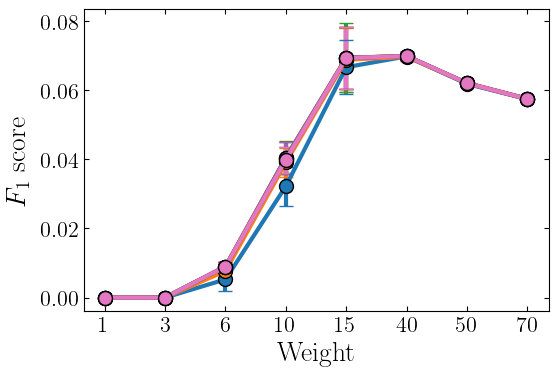

In [79]:
df = pd.DataFrame(clf.cv_results_)
C_arr = np.logspace(-3,3,num=7)

for C in C_arr:
    reg_par_fixed = df.loc[df['param_C'] == C]
    N_rows = reg_par_fixed.shape[0]
    weights = np.zeros(N_rows)
    means = np.zeros(N_rows)
    stds = np.zeros(N_rows)

    for i in range(N_rows):
        row = reg_par_fixed.iloc[i]
        w = row['param_class_weight']
        weights[i] = w[1]
        scores = row.loc['split0_test_score':'split4_test_score']
        means[i] = np.mean(scores)
        stds[i] = np.std(scores)

    x = np.arange(0,N_rows)
    plt.errorbar(x,means,yerr=stds,marker='o',capsize=5,lw=3,mec='k',ms=10)
    x_tick_locs = np.arange(0,N_rows)

    plt.xticks(x_tick_locs,["%d" %w for w in weights])
    
plt.xlabel('Weight')
plt.ylabel(r'$F_1$ score')

Text(0, 0.5, '$F_1$ score')

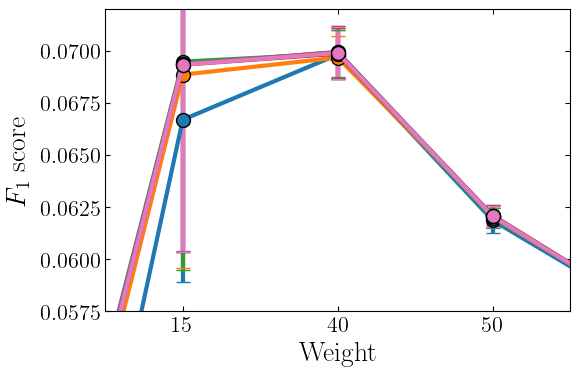

In [80]:
df = pd.DataFrame(clf.cv_results_)
C_arr = np.logspace(-3,3,num=7)

for C in C_arr:
    reg_par_fixed = df.loc[df['param_C'] == C]
    N_rows = reg_par_fixed.shape[0]
    weights = np.zeros(N_rows)
    means = np.zeros(N_rows)
    stds = np.zeros(N_rows)

    for i in range(N_rows):
        row = reg_par_fixed.iloc[i]
        w = row['param_class_weight']
        weights[i] = w[1]
        scores = row.loc['split0_test_score':'split4_test_score']
        means[i] = np.mean(scores)
        stds[i] = np.std(scores)

    x = np.arange(0,N_rows)
    plt.errorbar(x,means,yerr=stds,marker='o',capsize=5,lw=3,mec='k',ms=10)
    x_tick_locs = np.arange(0,N_rows)

    plt.xticks(x_tick_locs,["%d" %w for w in weights]) 

plt.ylim(0.0575,0.072)
plt.xlim(3.5,6.5)

plt.xlabel('Weight')
plt.ylabel(r'$F_1$ score')

### We end up with best class weight of 15-40 ish. We could zoom in and rerun the grid search, but we can also just note that if we use weights according to how much each class appears in the dataset (i.e. $\texttt{class_weight='balanced'}$), since $p_\mathrm{inj} \sim 3 \%$, we'd have weights of $1:(1-p)/p \sim 1:33$, so using balanced class weights seems like a good choice.

### Now we'll pick a regularization parameter for that class weight, since our values were so close together before

In [78]:
reg_params = np.logspace(-4,4,num=20)

folds = 5
f1_scores = np.zeros((len(reg_params),folds))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
scaler = sklearn.preprocessing.StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

for i,C in enumerate(reg_params):
    
    print(i,C)
    
    model=LogisticRegression(max_iter=10000,class_weight='balanced',C=C,n_jobs=6)
    scores = model_selection.cross_validate(model, X_train, y_train, cv=folds,scoring='f1')                   
    f1_scores[i] = scores['test_score']

0 0.0001
1 0.00026366508987303583
2 0.0006951927961775605
3 0.0018329807108324356
4 0.004832930238571752
5 0.012742749857031334
6 0.03359818286283781
7 0.08858667904100823
8 0.23357214690901212
9 0.615848211066026
10 1.623776739188721
11 4.281332398719396
12 11.288378916846883
13 29.763514416313132
14 78.47599703514607
15 206.913808111479
16 545.5594781168514
17 1438.44988828766
18 3792.690190732246
19 10000.0


Text(0, 0.5, '$F_1$ score')

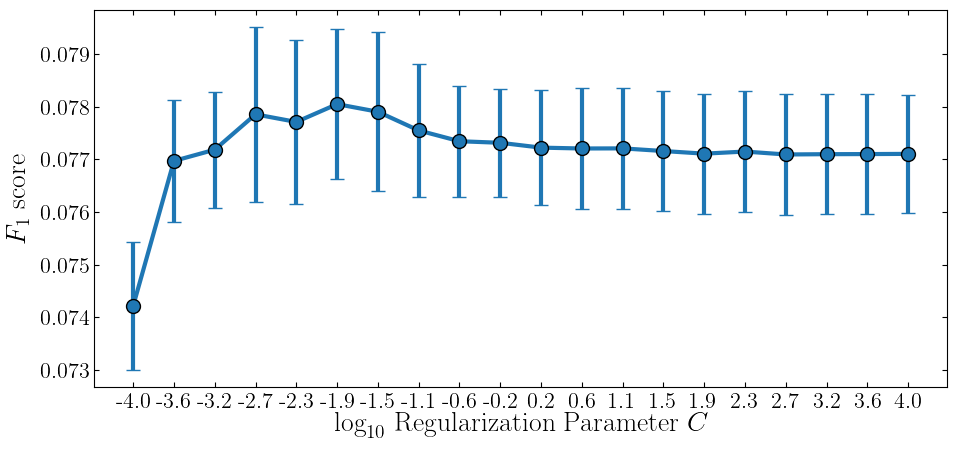

In [81]:
fig = plt.figure(figsize=(11,5))

means = np.mean(f1_scores,axis=1)
stds = np.std(f1_scores,axis=1)
x = np.arange(0,len(reg_params))
plt.errorbar(x,means,yerr=stds,marker='o',capsize=5,lw=3,mec='k',ms=10)
x_tick_locs = np.arange(0,len(reg_params))

plt.xticks(x_tick_locs,["%.1f" %np.log10(C) for C in reg_params])    

plt.xlabel("$\log_{10}$ Regularization Parameter $C$")
plt.ylabel(r'$F_1$ score')

### There's really not much variation, but let's zoom in on the best area.

In [82]:
reg_params = np.logspace(-3,-1,num=20)

folds = 5
f1_scores = np.zeros((len(reg_params),folds))

for i,C in enumerate(reg_params):
    
    print(i,C)
    
    model=LogisticRegression(max_iter=10000,class_weight='balanced',C=C)
    scores = model_selection.cross_validate(model, X_train, y_train, cv=folds,scoring='f1')                   
    f1_scores[i] = scores['test_score']

0 0.001
1 0.0012742749857031334
2 0.001623776739188721
3 0.00206913808111479
4 0.0026366508987303583
5 0.003359818286283781
6 0.004281332398719396
7 0.00545559478116852
8 0.0069519279617756054
9 0.008858667904100823
10 0.011288378916846888
11 0.01438449888287663
12 0.018329807108324356
13 0.023357214690901212
14 0.029763514416313176
15 0.0379269019073225
16 0.04832930238571752
17 0.06158482110660261
18 0.07847599703514611
19 0.1


Text(0, 0.5, '$F_1$ score')

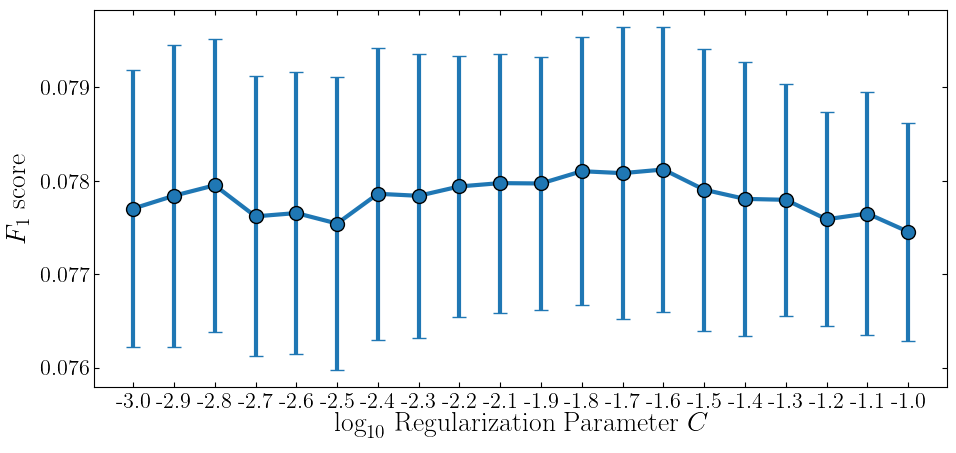

In [83]:
fig = plt.figure(figsize=(11,5))

means = np.mean(f1_scores,axis=1)
stds = np.std(f1_scores,axis=1)
x = np.arange(0,len(reg_params))
plt.errorbar(x,means,yerr=stds,marker='o',capsize=5,lw=3,mec='k',ms=10)
x_tick_locs = np.arange(0,len(reg_params))

plt.xticks(x_tick_locs,["%.1f" %np.log10(C) for C in reg_params])    

plt.xlabel("$\log_{10}$ Regularization Parameter $C$")
plt.ylabel(r'$F_1$ score')

#### Unsurprisingly there's not much change, but we'll pick the best parameters and then finally train a classifer.

In [84]:
C_best = reg_params[np.argmax(means)]
print('Best regularization parameter (neglecting error): {:.3g}'.format(C_best))

Best regularization parameter (neglecting error): 0.0234


### Try training with that amount of regularization

In [56]:
model=LogisticRegression(verbose=True,max_iter=10000,class_weight='balanced',C=0.0234)
model.fit(X_train,y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s finished


LogisticRegression(C=0.0234, class_weight='balanced', max_iter=10000,
                   verbose=True)

In [57]:
predicted = model.predict(X_test)
probs = model.predict_proba(X_test)

In [58]:
print(metrics.accuracy_score(y_test, predicted))
print(metrics.classification_report(y_test, predicted))

cm = metrics.confusion_matrix(y_test,predicted)
print(cm)

0.6503246362871228
              precision    recall  f1-score   support

         0.0       0.98      0.65      0.78     32286
         1.0       0.04      0.53      0.08       982

    accuracy                           0.65     33268
   macro avg       0.51      0.59      0.43     33268
weighted avg       0.95      0.65      0.76     33268

[[21112 11174]
 [  459   523]]


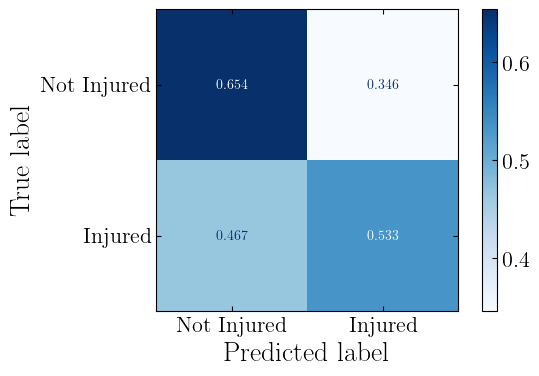

In [61]:
class_names = ['Not Injured','Injured']
disp_per = sklearn.metrics.plot_confusion_matrix(model, X_test, y_test,
                                 display_labels=class_names,
                                 cmap=plt.cm.Blues,
                                 normalize='true',values_format='.3f')

disp_per.ax_

### This does OK, we're catching more than half the injuries and "only" misclassifying around a 1/3 of the non-injured games. Of course in terms of absoulte numbers that's a huge amount of false postivies

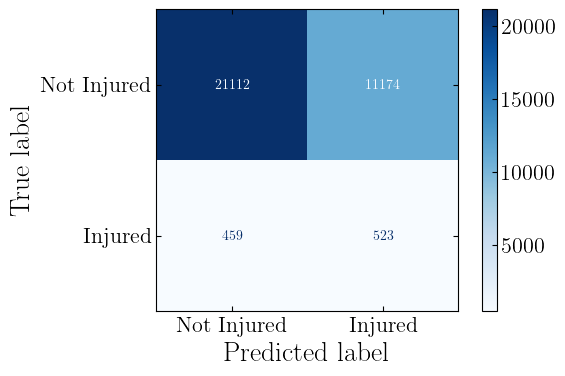

In [66]:
class_names = ['Not Injured','Injured']
disp_abs = sklearn.metrics.plot_confusion_matrix(model, X_test, y_test,
                                 display_labels=class_names,
                                 cmap=plt.cm.Blues,
                                 values_format='d')

disp_abs.ax_

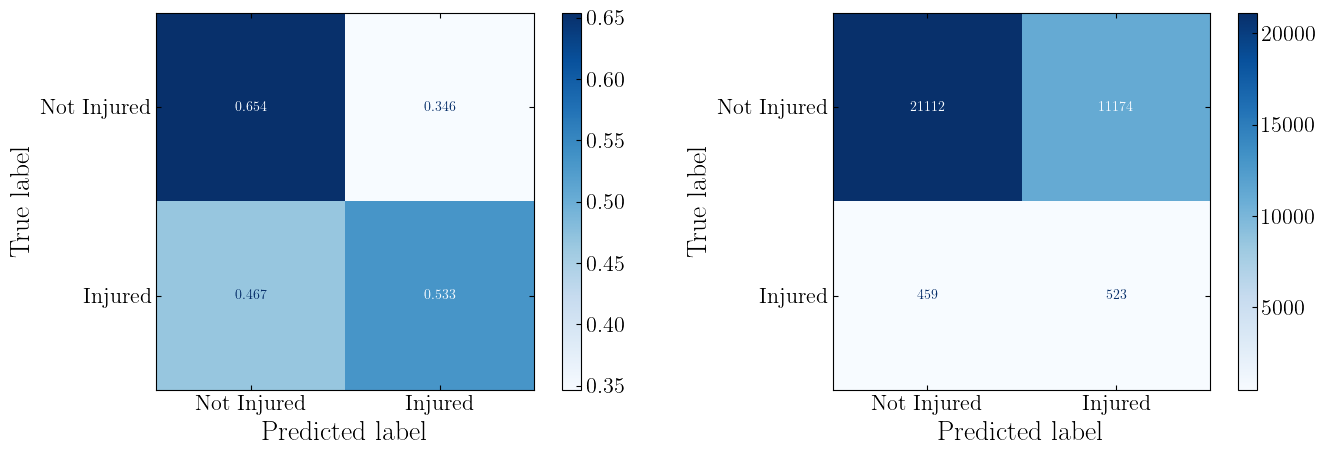

In [92]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(16,5))


disp_per = sklearn.metrics.plot_confusion_matrix(model, X_test, y_test,
                                 display_labels=class_names,
                                 cmap=plt.cm.Blues,
                                 normalize='true',values_format='.3f',ax=ax1)

disp_abs = sklearn.metrics.plot_confusion_matrix(model, X_test, y_test,
                                 display_labels=class_names,
                                 cmap=plt.cm.Blues,
                                 values_format='d',ax=ax2)


In [93]:
fig.savefig('con_mat_fig.png',bbox_inches='tight',dpi=300)

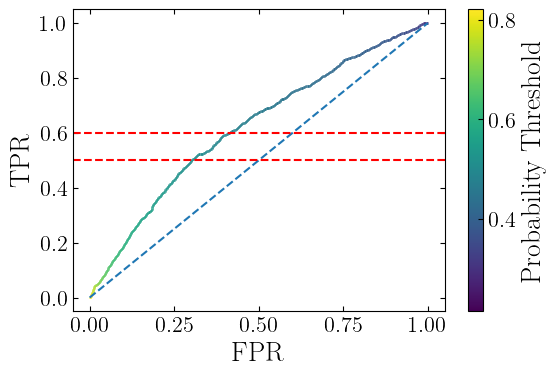

In [85]:
from matplotlib.collections import LineCollection

fpr, tpr, thresholds = metrics.roc_curve(y_test,probs[:,1])

fig = plt.figure()

# plt.plot(fpr,tpr)
plt.plot(fpr,fpr,linestyle='dashed')

plt.xlabel("FPR")
plt.ylabel("TPR")

plt.axhline(y=0.5,color='r',linestyle='dashed')
plt.axhline(y=0.6,color='r',linestyle='dashed')

points = np.array([fpr, tpr]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)

norm = plt.Normalize(thresholds.min(), thresholds[np.where(tpr<0.01)[0][-1]])
lc = LineCollection(segments, cmap='viridis', norm=norm)
# Set the values used for colormapping
lc.set_array(thresholds)
lc.set_linewidth(2)
line = plt.gca().add_collection(lc)
cb = fig.colorbar(line, ax=plt.gca())
cb.set_label('Probability Threshold')

# plt.axis([0,0.1,0,0.1])

In [87]:
fig.savefig('roc_simple.png',dpi=300)

In [97]:
games_added = 5.889 - 1 #Avg missed games from missed_games notebook - 1 because the player is rested in that game

print("Total missed games due to misclassifed injuries: {:d}\nTotal games added because of \
correctly classified injuries: {:d}".format(cm[0,1],int(cm[1,1]*games_added)))

Total missed games due to misclassifed injuries: 11409
Total games added because of correctly classified injuries: 2708


In [145]:
def net_games(estimator, X, y_true):
    predicted = estimator.predict(X)
    cm = metrics.confusion_matrix(y_true,predicted)
    return games_added*cm[1,1]-cm[0,1]

In [146]:
net_games(model,X_test,y_test)

-8617.053

### So if we tried to use this classifer to actually predict injuries we'd actually lose playing time, as the games gained due to missing the injury are outweighed by the times we incorrectly rest a player.

### Finally, let's use recursive feature elimination to try a fancier way of finding the best performing features

In [101]:
from sklearn.feature_selection import RFECV

y = injs['Was_Injured']
X = injs.drop(columns=['Was_Injured','Dist_Feet_Av_7','Dist_Feet_Av_14','Dist_Feet_Av_21','Date','Name'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
scaler = sklearn.preprocessing.StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [103]:
log_reg = LogisticRegression(max_iter=10000,class_weight='balanced',C=C_best)
rfe = RFECV(estimator=log_reg, step=3,scoring='f1',verbose=True)
rfe.fit(X_train, y_train)

Fitting estimator with 138 features.
Fitting estimator with 135 features.
Fitting estimator with 132 features.
Fitting estimator with 129 features.
Fitting estimator with 126 features.
Fitting estimator with 123 features.
Fitting estimator with 120 features.
Fitting estimator with 117 features.
Fitting estimator with 114 features.
Fitting estimator with 111 features.
Fitting estimator with 108 features.
Fitting estimator with 105 features.
Fitting estimator with 102 features.
Fitting estimator with 99 features.
Fitting estimator with 96 features.
Fitting estimator with 93 features.
Fitting estimator with 90 features.
Fitting estimator with 87 features.
Fitting estimator with 84 features.
Fitting estimator with 81 features.
Fitting estimator with 78 features.
Fitting estimator with 75 features.
Fitting estimator with 72 features.
Fitting estimator with 69 features.
Fitting estimator with 66 features.
Fitting estimator with 63 features.
Fitting estimator with 60 features.
Fitting estimat

Fitting estimator with 6 features.
Fitting estimator with 3 features.
Fitting estimator with 138 features.
Fitting estimator with 135 features.
Fitting estimator with 132 features.
Fitting estimator with 129 features.
Fitting estimator with 126 features.
Fitting estimator with 123 features.
Fitting estimator with 120 features.
Fitting estimator with 117 features.
Fitting estimator with 114 features.
Fitting estimator with 111 features.
Fitting estimator with 108 features.
Fitting estimator with 105 features.
Fitting estimator with 102 features.
Fitting estimator with 99 features.
Fitting estimator with 96 features.
Fitting estimator with 93 features.
Fitting estimator with 90 features.
Fitting estimator with 87 features.
Fitting estimator with 84 features.
Fitting estimator with 81 features.
Fitting estimator with 78 features.
Fitting estimator with 75 features.
Fitting estimator with 72 features.
Fitting estimator with 69 features.
Fitting estimator with 66 features.
Fitting estimator

RFECV(estimator=LogisticRegression(C=0.023357214690901212,
                                   class_weight='balanced', max_iter=10000),
      scoring='f1', step=3, verbose=True)

In [104]:
X.columns[rfe.support_]

Index(['Age', 'MP_Av14', '3P_Av14', '3PA_Av14', 'FTA_Av14', 'DRB_Av14',
       'MP_Av21', 'FTA_Av21', 'FT_per_Av21', 'DRB_Av21', 'FTA_b2b',
       'FT_per_b2b', 'N_prev_injs', 'W_Av_7', 'L_Av_7', 'Dist_Miles_Off_Av_7',
       'W_Av_14', 'L_Av_14', 'Dist_Miles_Def_Av_14', 'Avg_Speed_Off_Av_14',
       'L_Av_21', 'Dist_Miles_Av_21', 'Dist_Miles_Def_Av_21',
       'Avg_Speed_Off_Av_21'],
      dtype='object')

In [106]:
y = injs['Was_Injured']
X = injs[X.columns[rfe.support_]]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
scaler = sklearn.preprocessing.StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [107]:
model=LogisticRegression(verbose=True,max_iter=10000,class_weight='balanced',C=C_best)
model.fit(X_train,y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s finished


LogisticRegression(C=0.023357214690901212, class_weight='balanced',
                   max_iter=10000, verbose=True)

In [114]:
coeffs = pd.DataFrame(zip(X.columns, np.transpose(model.coef_)))
coeffs.loc[coeffs[1].abs().argsort()[::-1]]

,0,1
12,N_prev_injs,[0.366336917657065]
18,Dist_Miles_Def_Av_14,[-0.35757022577652153]
22,Dist_Miles_Def_Av_21,[0.3569569505744481]
7,FTA_Av21,[0.2803375557758927]
1,MP_Av14,[0.2105739495689191]
6,MP_Av21,[-0.19986942890185028]
11,FT_per_b2b,[-0.14801049647219575]
4,FTA_Av14,[-0.14085735325788876]
2,3P_Av14,[-0.13282738658773047]
3,3PA_Av14,[0.12109397045412716]


In [108]:
predicted = model.predict(X_test)
probs = model.predict_proba(X_test)

In [109]:
print(metrics.accuracy_score(y_test, predicted))
print(metrics.classification_report(y_test, predicted))

cm = metrics.confusion_matrix(y_test,predicted)
print(cm)

0.6504148130335458
              precision    recall  f1-score   support

         0.0       0.98      0.65      0.78     32324
         1.0       0.04      0.54      0.08       944

    accuracy                           0.65     33268
   macro avg       0.51      0.59      0.43     33268
weighted avg       0.95      0.65      0.76     33268

[[21132 11192]
 [  438   506]]


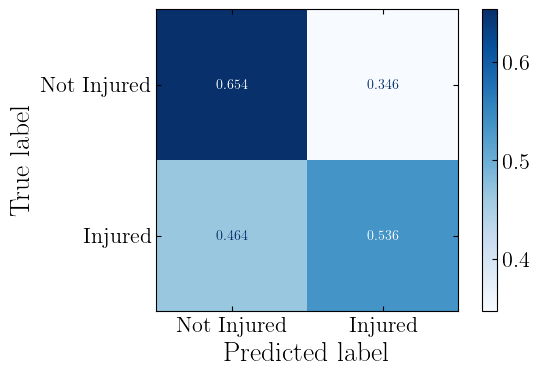

In [110]:
class_names = ['Not Injured','Injured']
disp = sklearn.metrics.plot_confusion_matrix(model, X_test, y_test,
                                 display_labels=class_names,
                                 cmap=plt.cm.Blues,
                                 normalize='true',values_format='.3f')

disp.ax_

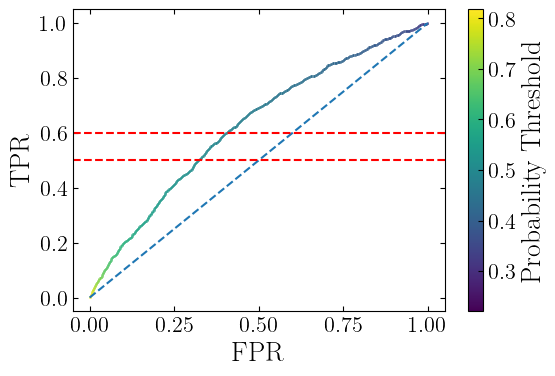

In [111]:
from matplotlib.collections import LineCollection

fpr, tpr, thresholds = metrics.roc_curve(y_test,probs[:,1])

fig = plt.figure()

# plt.plot(fpr,tpr)
plt.plot(fpr,fpr,linestyle='dashed')

plt.xlabel("FPR")
plt.ylabel("TPR")

plt.axhline(y=0.5,color='r',linestyle='dashed')
plt.axhline(y=0.6,color='r',linestyle='dashed')

points = np.array([fpr, tpr]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)

norm = plt.Normalize(thresholds.min(), thresholds[np.where(tpr<0.01)[0][-1]])
lc = LineCollection(segments, cmap='viridis', norm=norm)
# Set the values used for colormapping
lc.set_array(thresholds)
lc.set_linewidth(2)
line = plt.gca().add_collection(lc)
cb = fig.colorbar(line, ax=plt.gca())
cb.set_label('Probability Threshold')

# plt.axis([0,0.1,0,0.1])

In [143]:
games_added = 5.889 - 1 #Avg missed games from missed_games notebook - 1 because the player is rested in that game

print("Total missed games due to misclassifed injuries: {:d}\nTotal games added because of \
correctly classified injuries: {:d}".format(cm[0,1],int(cm[1,1]*games_added)))

Total missed games due to misclassifed injuries: 11174
Total games added because of correctly classified injuries: 2556


In [147]:
net_games(model,X_test,y_test)

-8617.053

## Try a grid search using net games as the scoring metric

In [155]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
scaler = sklearn.preprocessing.StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [156]:
params = [{'class_weight' : [{0:1,1:1},{0:1,1:3},{0:1,1:6},{0:1,1:10},{0:1,1:15},{0:1,1:40}\
                    ,{0:1,1:50},{0:1,1:70}],'C': np.logspace(-3,3,num=7)}]
       
model=LogisticRegression(max_iter=10000,n_jobs=12)

clf = model_selection.GridSearchCV(model,params,scoring=net_games,verbose=3,n_jobs=12)

clf.fit(X_train,y_train)

Fitting 5 folds for each of 56 candidates, totalling 280 fits


[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done   8 tasks      | elapsed:    3.2s
[Parallel(n_jobs=12)]: Done 104 tasks      | elapsed:  1.0min
[Parallel(n_jobs=12)]: Done 280 out of 280 | elapsed:  5.3min finished


GridSearchCV(estimator=LogisticRegression(max_iter=10000, n_jobs=12), n_jobs=12,
             param_grid=[{'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                          'class_weight': [{0: 1, 1: 1}, {0: 1, 1: 3},
                                           {0: 1, 1: 6}, {0: 1, 1: 10},
                                           {0: 1, 1: 15}, {0: 1, 1: 40},
                                           {0: 1, 1: 50}, {0: 1, 1: 70}]}],
             scoring=<function net_games at 0x1351aa268>, verbose=3)

In [157]:
print(clf.best_score_,clf.best_params_)

0.0 {'C': 0.001, 'class_weight': {0: 1, 1: 1}}


## Use statsmodels and backwards stepwise regression to select a model

In [78]:
import statsmodels as sm
from statsmodels.discrete.discrete_model import Logit

In [131]:
current_score = 1e-100

y = injs['Was_Injured']
X = injs[sort.index[1:61]]

X_new = X.copy()

while X.shape[0]>0:
      
    logit = Logit(y, X_new)
    result = logit.fit(maxiter=10000)
    
    new_score = result.aic
    print("New AIC = {:.3f}\n".format(new_score))
    if new_score < current_score:
        print("AIC went down, ending fitting")
        break
        
    current_score = new_score
    
    best_model = result
    X_best = X_new.copy()
    worst_cols = result.pvalues.index[result.pvalues.values.argsort()[::-1]]
    worst_feature = worst_cols[0]
    print("Dropping feature {:s}\n".format(worst_feature))
    
    X_new = X_new.drop(columns=worst_cols[0])

Optimization terminated successfully.
         Current function value: 0.129670
         Iterations 8
New AIC = 34628.974

Dropping feature DRB_b2b

Optimization terminated successfully.
         Current function value: 0.129670
         Iterations 8
New AIC = 34628.974

Dropping feature TRB_b2b

Optimization terminated successfully.
         Current function value: 0.129670
         Iterations 8
New AIC = 34626.975

AIC went down, ending fitting


In [132]:
best_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:            Was_Injured   No. Observations:               133072
Model:                          Logit   Df Residuals:                   133013
Method:                           MLE   Df Model:                           58
Date:                Mon, 22 Jun 2020   Pseudo R-squ.:                 0.01832
Time:                        11:49:48   Log-Likelihood:                -17255.
converged:                       True   LL-Null:                       -17577.
Covariance Type:            nonrobust   LLR p-value:                8.972e-100
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
N_prev_injs             0.0568      0.003     20.387      0.000       0.051       0.062
N_games_14             -0.0394      0.025     -1.576      0.115      -0.088       0.010
N_games_7              -0.0689      0.027     -2.507      0.012      -0.123      -0.015
N_games_21              0.0146      0.015      0.953      0.340      -0.015       0.045
FT_Av21                -0.1586      0.133     -1.192      0.233      -0.419       0.102
FGA_Av21                0.0225      0.048      0.467      0.640      -0.072       0.117
FTA_Av21                0.1759      0.093      1.891      0.059      -0.006       0.358
AST_Av21                0.0330      0.057      0.581      0.561      -0.078       0.144
W_Av_14                -0.0139      0.028     -0.500      0.617      -0.068       0.041
TOV_Av14                0.0601      0.082      0.732      0.464      -0.101       0.221
TOV_Av21               -0.0637      0.084     -0.759      0.448      -0.228       0.101
FGA_Av14               -0.0231      0.046     -0.497      0.619      -0.114       0.068
PTS_Av21                0.0527      0.090      0.587      0.557      -0.123       0.229
W_Av_21                -0.0308      0.019     -1.620      0.105      -0.068       0.006
AST_Av14               -0.0046      0.060     -0.077      0.939      -0.122       0.113
FT_Av14                 0.2712      0.140      1.935      0.053      -0.003       0.546
FG_Av21                -0.1890      0.182     -1.039      0.299      -0.545       0.167
GmSc_Av21               0.0159      0.056      0.284      0.776      -0.094       0.126
ann_inj_rate           -0.9697      0.529     -1.832      0.067      -2.007       0.067
PTS_Av14               -0.1343      0.096     -1.392      0.164      -0.323       0.055
FTA_Av14               -0.1260      0.097     -1.301      0.193      -0.316       0.064
FGA_Av7                -0.0014      0.021     -0.065      0.948      -0.043       0.040
FG_Av14                 0.3463      0.198      1.752      0.080      -0.041       0.734
AST_Av7                 0.0071      0.029      0.246      0.806      -0.049       0.063
Avg_Speed_Def_Av_21    -0.1793      0.150     -1.197      0.231      -0.473       0.114
TOV_Av7                -0.0058      0.038     -0.153      0.879      -0.080       0.069
W_Av_7                  0.0079      0.027      0.297      0.767      -0.044       0.060
GmSc_Av14              -0.0189      0.054     -0.349      0.727      -0.125       0.087
PTS_Av7                 0.0407      0.046      0.886      0.375      -0.049       0.131
Avg_Speed_Av_21        -0.2522      0.217     -1.162      0.245      -0.678       0.173
FG_Av7                 -0.0715      0.096     -0.742      0.458      -0.261       0.118
Avg_Speed_Av_14        -0.1498      0.218     -0.686      0.493      -0.578       0.278
FT_Av7                 -0.0383      0.070     -0.550      0.582      -0.174       0.098
FG_per_b2b             -0.4528      0.247     -1.830      0.067      -0.9

In [154]:
best_model.pvalues.index[np.where(best_model.pvalues<0.1)]

Index(['N_prev_injs', 'N_games_7', 'FTA_Av21', 'FT_Av14', 'ann_inj_rate',
       'FG_Av14', 'FG_per_b2b', 'PF_b2b', 'Age', 'b2b', '3P_per_b2b',
       'PTS_b2b', 'FT_b2b'],
      dtype='object')

In [141]:
statmodels_prob = best_model.predict(X_best)
len(statmodels_prob.values[np.where(statmodels_prob>0.2)])

63